# Preprocessing and quality control of solar data
*Date: May 5th, 2020*



## Import python modules

First import the necessary modules:

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import sys
from lib import wps
from lib.utils import *

## Load dataframe including measurements and sun position information

In [11]:
# Get data saved from Chapter 01, or fetch it again over opendap
QC_df = fetch_data()

In [14]:
# Get meta data attached to dataframe
Latitude = float(QC_df.attrs["Station_Latitude"])
Longitude = float(QC_df.attrs["Station_Longitude"])
Elevation = float(QC_df.attrs["Station_Elevation"])

## Visual inspection of the time series

The first check of the data consists of a visualization of the time series of data. For this purpose, the different measurements have been represented as a function of time in Fig. 4. To facilitate the visualization of the data, the daily averages of the measurements were superimposed on the measurements with a time resolution of 10 min. Generally, this first qualitative analysis allows detecting major issues in the measurement. For our test sites, only slightly high DHI values can be observed for some stations. Nevertheless, it is not possible to judge their plausibility at this stage of the data analysis.

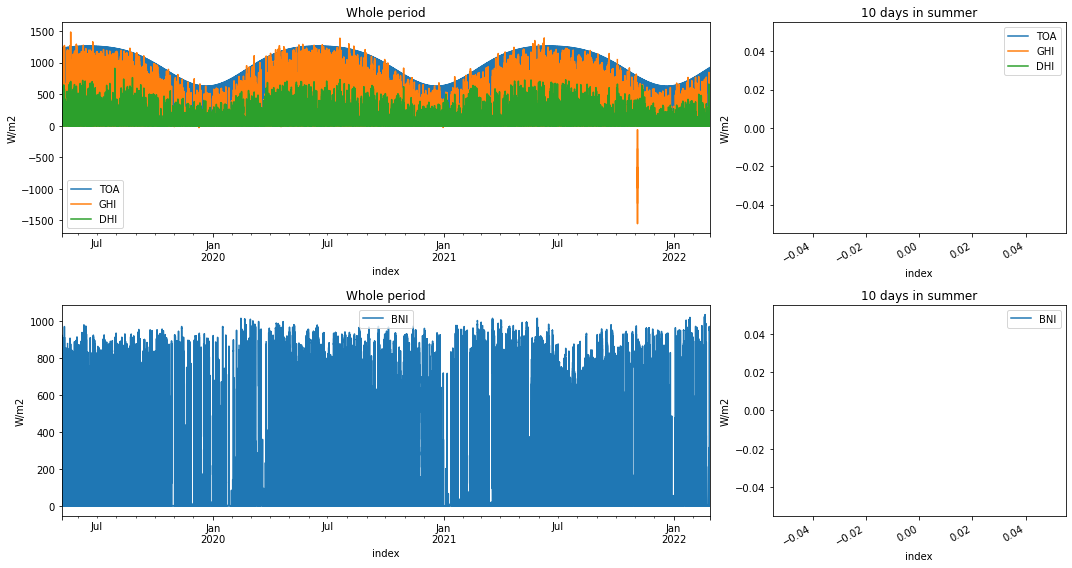

In [15]:
# Plotting the data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,8))

ax11 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
QC_df[['TOA','GHI','DHI']].plot(title='Whole period',ax=ax11)
plt.ylabel('W/m2')

ax12 = plt.subplot2grid((2, 3), (0, 2))
QC_df[['TOA','GHI','DHI']].loc[(QC_df.index >dt.datetime(2005,7,1)) & (QC_df.index <= dt.datetime(2005,7,10))].plot(title='10 days in summer',ax=ax12)
plt.ylabel('W/m2')

ax21 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
QC_df[['BNI']].plot(title='Whole period',ax=ax21)
plt.ylabel('W/m2')

ax22 = plt.subplot2grid((2, 3), (1, 2))
QC_df[['BNI']].loc[(QC_df.index >dt.datetime(2005,7,1)) & (QC_df.index <= dt.datetime(2005,7,10))].plot(title='10 days in summer',ax=ax22)
plt.ylabel('W/m2')

plt.tight_layout()

### 4. Control of the time system using a two-dimensional time representation
***
we display measurement in a two-dimensional representation, where the x-axis represents the day, the y-axis the time of day and the dots' color the value of the data considered: the GHI, DNI or DHI, the white bands indicate missing or non-existent values. This analysis allows to visually identify errors over time, to visualize missing values, issue in the time reference, abnormal values and sometimes shading problems.



In order to validate the data, we calculate the theoretical time of sunset and sunrise from the latitude using the sunrise equation with corrections for atmospherical refraction and solar disc diameter:

\begin{equation*}
cos \left(\omega_{0} \right) = \frac{sin ⁡ ( − 0.83 ° ) − sin \,⁡ \phi \, \times sin \, \delta}{cos \,⁡ \phi \, \times cos \, \delta}
\label{eq:sunrise_equation} \tag{1}
\end{equation*}

where:

    ωo is is the hour angle;
    ϕ is the north latitude of the observer (north is positive, south is negative) on the Earth.
    δ is the declination of the sun.

Using Eq. $\eqref{eq:sunrise_equation}$, the time of the day corresponding to the sunset and sunrise are calculated for each day of the period of analysis. This implies a longitude correction and the consideration of the equation of time (not detailed here). The resulting sunrise and sunset times are represented by a dotted red line in the figure below.

/home/rjolivet/IEA_PVPS_T16_QC_pynb/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


ValueError: cannot reshape array of size 1480748 into shape (1028,1440)

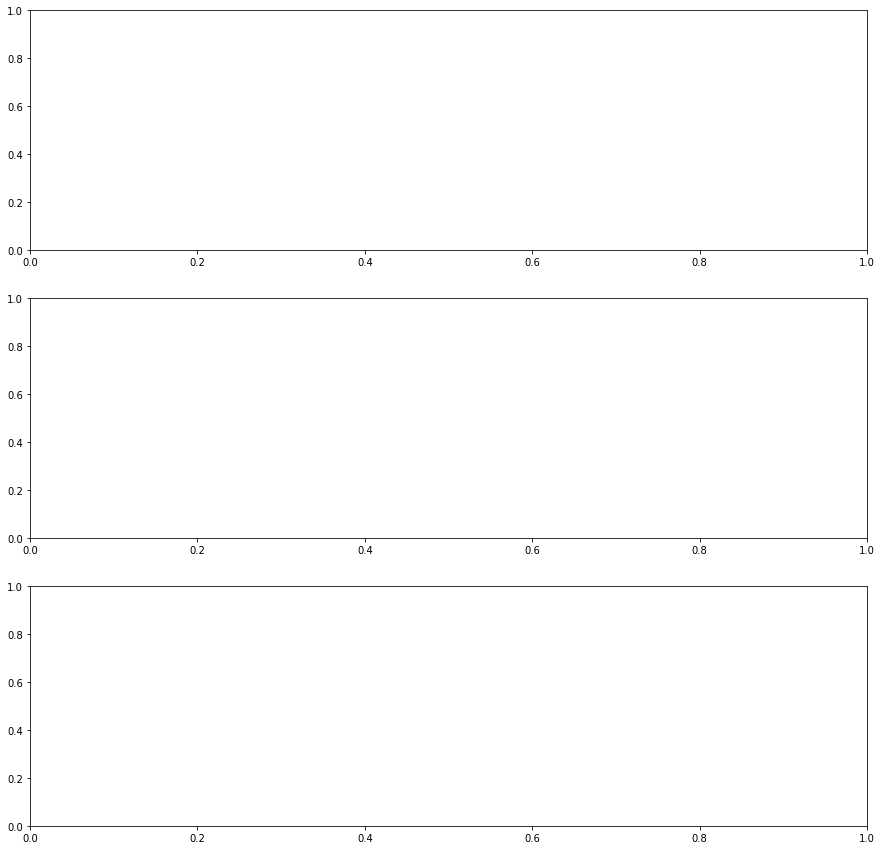

In [16]:
#%% Control of the time system using a two-dimensional time representation

# generation of a colormap with light colours for the night
nt_nb=(6,128)
top = cm.get_cmap('Blues', nt_nb[0])
bottom = cm.get_cmap('jet', nt_nb[1])
newcolors = np.vstack((top(np.linspace(0, 1, nt_nb[0])),bottom(np.linspace(0, 1, nt_nb[1]))))
newcmp = ListedColormap(newcolors, name='jet_ymsd')


x_lims = [QC_df.index[0].date(),QC_df.index[-1].date()]
x_lims = mdates.date2num(x_lims)
y_lims = [0, 24]
nb_min=24*60
nb_days=np.int(QC_df.shape[0]/nb_min)

x_timeidx=mdates.date2num(QC_df.index)


fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))

im1=ax1.imshow(np.reshape(QC_df.GHI.values,(nb_days,nb_min)).T,
           extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]],
           aspect='auto',cmap=newcmp)
ax1.xaxis_date()
ax1.set_xlabel('Days')
ax1.set_yticks(np.arange(0,25,3))
ax1.set_ylabel('Time of the day')
ax1.plot(x_timeidx,QC_df.SR_h,'r--')
ax1.plot(x_timeidx,QC_df.SS_h,'r--')
cbar =fig.colorbar(im1, ax=ax1, orientation='vertical')
cbar.set_label('GHI', rotation=270)
ax1.set_title('GHI')


im2=ax2.imshow(np.reshape(QC_df.BNI.values,(nb_days,nb_min)).T,
           extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]],
           aspect='auto',cmap=newcmp)
ax2.xaxis_date()
ax2.set_xlabel('Days')
ax2.set_yticks(np.arange(0,25,3))
ax2.set_ylabel('Time of the day')
ax2.plot(x_timeidx,QC_df.SR_h,'r--')
ax2.plot(x_timeidx,QC_df.SS_h,'r--')
cbar =fig.colorbar(im2, ax=ax2, orientation='vertical')
cbar.set_label('BNI', rotation=270)
ax2.set_title('BNI')


im3=ax3.imshow(np.reshape(QC_df.DHI.values,(nb_days,nb_min)).T,
           extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]],
           aspect='auto',cmap=newcmp)
ax3.xaxis_date()
ax3.set_xlabel('Days')
ax3.set_yticks(np.arange(0,25,3))
ax3.set_ylabel('Time of the day')
cbar =fig.colorbar(im3, ax=ax3, orientation='vertical')
cbar.set_label('DHI', rotation=270)
ax3.set_title('DHI')
ax3.plot(x_timeidx,QC_df.SR_h,'r--')
ax3.plot(x_timeidx,QC_df.SS_h,'r--')

fig.tight_layout()

### 5. Shadow detection
***


latitude=40.050000;longitude=-88.370000;altitude=213.0
CPU times: user 183 ms, sys: 12.2 ms, total: 195 ms
Wall time: 1.41 s


(45.0, 315.0)

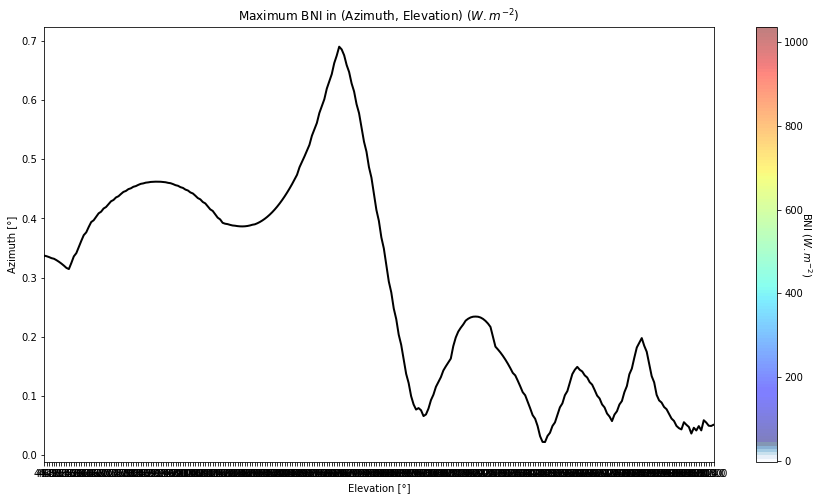

In [17]:
%%time
#%% Analysis of the shadow surrounding the station

vSEA = QC_df.loc[QC_df.GAMMA_S0>1/50,'GAMMA_S0']
vSAA = QC_df.loc[QC_df.GAMMA_S0>1/50,'ALPHA_S']
vBNI = QC_df.loc[QC_df.GAMMA_S0>1/50,'BNI']


idx_sort = np.argsort(vBNI.values)

# call the wps to obtain the horiyon line calculated with SRTM elevation data
location = [Latitude, Longitude, Elevation]
HZ = wps.wps_Horizon_SRTM(location)

fig = plt.figure(figsize=(15,8))
plt.scatter(vSAA[idx_sort]*180/np.pi, vSEA[idx_sort]*180/np.pi, s=5, c=vBNI[idx_sort], cmap=newcmp,marker='s',alpha=.5)
plt.title(r'Maximum BNI in (Azimuth, Elevation) $(W.m^{-2})$')
plt.xlabel('Elevation [°]')
plt.ylabel('Azimuth [°]')
cb=plt.colorbar()
plt.plot(HZ.AZIMUT,HZ.ELEVATION,'k',linewidth=2)
cb.set_label('BNI $(W.m^{-2})$', rotation=270)
plt.xlim((45,315))  

Select the data that are not shaded (for the moment above the horizon line)

In [18]:
QC_horizon=(QC_df['GAMMA_S0']*180/np.pi<np.interp(QC_df['ALPHA_S']*180/np.pi,HZ.AZIMUT,HZ.ELEVATION)) &\
    (QC_df['GAMMA_S0']>1/50)


fig = plt.figure(figsize=(15,8))
plt.scatter(vSAA[QC_df['GAMMA_S0']>1/50]*180/np.pi, vSEA[QC_df['GAMMA_S0']>1/50]*180/np.pi, s=5, c=QC_horizon[QC_df['GAMMA_S0']>1/50],marker='s',alpha=.5)
plt.title(r'Maximum BNI in (Azimuth, Elevation) $(W.m^{-2})$')
plt.xlabel('Elevqtion [°]')
plt.ylabel('Azimuth [°]')
cb=plt.colorbar()
plt.plot(HZ.AZIMUT,HZ.ELEVATION,'k',linewidth=2)
cb.set_label('Shading QC flag', rotation=270)
plt.xlim((45,315))  

ValueError: could not convert string to float: '                    <wps:ComplexData mimeType="application/csv" encoding="" schema=""><![CDATA['

### 6. One-component quality control
***
To verify the validity of the measurements, we apply the test proposed by Long and Dutton and recommanded by BSRN. These tests can be found on: 
https://bsrn.awi.de/fileadmin/user_upload/bsrn.awi.de/Publications/BSRN_recommended_QC_tests_V2.pdf
This first quality control consists in a set of two tests for each physical quantity: the physically possible limit and the extremely rare limit tests. These are detailed for the GHI, the DHI and the BNI below:

**Physically Possible Limits (PPL)** check the maximum and minimum limits that can be reached by irradiance, the upper limits depend on the solar zenith angle, the minimal value of solar irradiance must be 0 W/m², but because of the radiative cooling at night the limit is set at -4 w/m2, the test applies independently to each of the three components as follows:

$-4 \leq GHI \leq 1.5 \, I_{0} \, cos(SZA)^{1.2}+100$

$-4 \leq DHI \leq 0.95 \, I_{0} \, cos(SZA)^{1.2} +50 $

$-4 \leq DNI \leq  I_{0} $

The limits of the **"Extremely Rare Limits"(ERL)** procedure are more strict than those of the "Physically Possible" test. ERL differs from the PPL test in that the measurements rarely reach these limits, and even if the case is only for short periods of a few seconds to one or two minutes, and also in those measurements violating these limits are not necessarily incorrect but their plausibility should be checked more specifically. The ERL limits are defined as follows:

$-2 \leq GHI \leq 1.2 \, I_{0} \, cos(SZA)^{1.2}+50$

$-2 \leq DHI \leq 0.75 \, I_{0} \, cos(SZA)^{1.2} +30 $

$-2 \leq DNI \leq  0.95 \, cos(SZA)^{0.2} + 10$

This set of test allows flagging each value. 

A graphical representation of these two tests is possible by representing the 10-minute averages of GHI, DHI or DNI as a function of the irradiance received at the top of the atmosphere (TOA). This representation is shown in Fig. 7 where the one-component PPL and ERL tests are represented by green and red lines respectively.
In view of the QC equations, it might have been simpler to use the cosine of the zenith solar angle for the graphical representation of the QC. However, we opted for the irradiance at the top of the atmosphere because we judged this quantity to be more intuitive. Finally, another quantity would have been more suitable to represent the quality control of the DNI but we chose to keep the same quantity between the different representations for consistency reasons.
 <blockquote>
    NB: add tests from:
https://hal-mines-paristech.archives-ouvertes.fr/hal-01493608/document
</blockquote>

Wall time: 3.93 s


Text(0, 0.5, 'BNI [W/m2]')

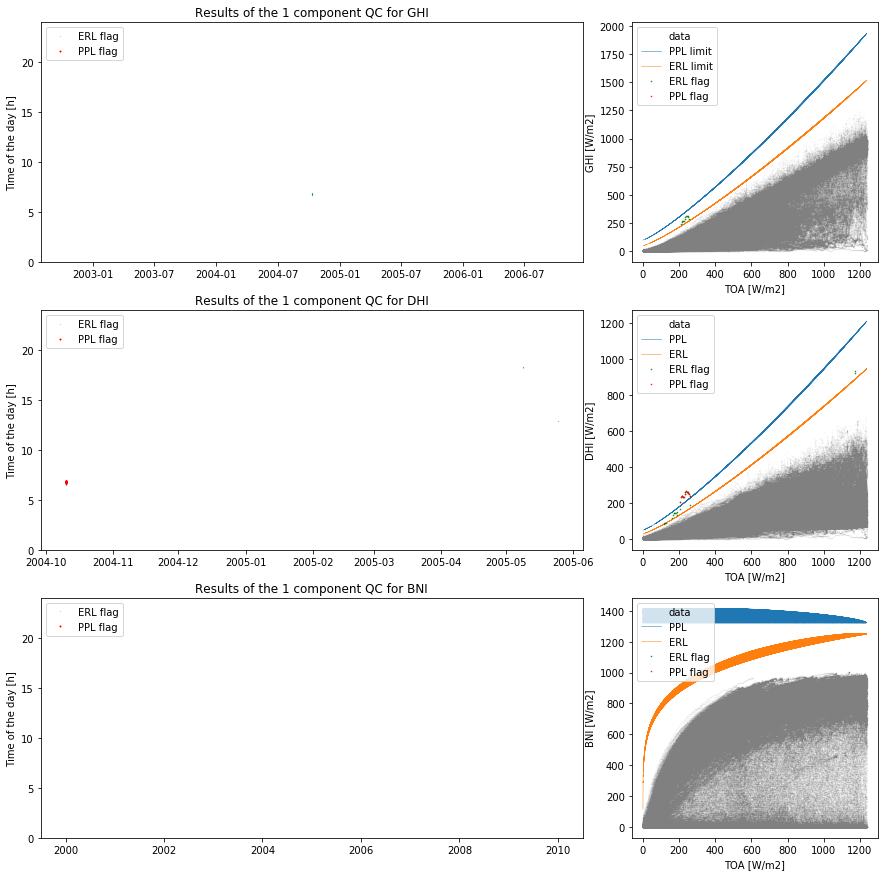

In [21]:
%%time
#%% QC one component for GHI, DHI and BNI
import matplotlib.pyplot as plt

QCFlag_Test1C_ppl_GHI=(QC_df.GHI <= -4) | (QC_df.GHI > 1.5*QC_df.TOANI*np.sin(QC_df.GAMMA_S0)**1.2 + 100)
QCFlag_Test1C_erl_GHI=(QC_df.GHI <= -2) | (QC_df.GHI > 1.2*QC_df.TOANI*np.sin(QC_df.GAMMA_S0)**1.2 + 50)

QCFlag_Test1C_ppl_DHI=(QC_df.DHI <= -4) | (QC_df.DHI > 0.95*QC_df.TOANI*np.sin(QC_df.GAMMA_S0)**1.2 + 50)
QCFlag_Test1C_erl_DHI=(QC_df.DHI <= -2) | (QC_df.DHI > 0.75*QC_df.TOANI*np.sin(QC_df.GAMMA_S0)**1.2 + 30)

QCFlag_Test1C_ppl_BNI=(QC_df.BNI <= -4) | (QC_df.BNI > QC_df.TOANI)
QCFlag_Test1C_erl_BNI=(QC_df.BNI <= -2) | (QC_df.BNI > 0.95*QC_df.TOANI*np.sin(QC_df.GAMMA_S0)**0.2 + 10)

day = QC_df.index.values.astype('datetime64[D]').astype(QC_df.index.values.dtype)
TOD = (QC_df.index.values - day).astype('timedelta64[s]').astype('double')/60/60

idx_sortTOA = np.argsort(QC_df.TOA.values)

plt.figure(figsize=(15,15))

ax11 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
idxERL=np.where(QCFlag_Test1C_erl_GHI)
plt.plot(day[idxERL],TOD[idxERL],'g.',markersize=0.2,label='ERL flag')
idxPPL=np.where(QCFlag_Test1C_ppl_GHI)
plt.plot(day[idxPPL],TOD[idxPPL],'r.',markersize=2,label='PPL flag')
plt.ylim((0,24))
plt.ylabel('Time of the day [h]')
plt.title("Results of the 1 component QC for GHI")
plt.legend(loc='upper left')

ax12 = plt.subplot2grid((3, 3), (0, 2), colspan=1)
plt.plot(QC_df.TOA,QC_df.GHI, '.',alpha=0.1,markersize=0.5,label='data',color=[0.5,0.5,0.5])
plt.plot(QC_df.TOA[idx_sortTOA],1.5*QC_df.TOANI[idx_sortTOA]*np.sin(QC_df.GAMMA_S0[idx_sortTOA])**1.2 + 100,linewidth=0.5,label='PPL limit')
plt.plot(QC_df.TOA[idx_sortTOA],1.2*QC_df.TOANI[idx_sortTOA]*np.sin(QC_df.GAMMA_S0[idx_sortTOA])**1.2 + 50,linewidth=0.5,label='ERL limit')
plt.plot(QC_df.TOA[QCFlag_Test1C_erl_GHI],QC_df.GHI[QCFlag_Test1C_erl_GHI],'g.',markersize=1,label='ERL flag')
plt.plot(QC_df.TOA[QCFlag_Test1C_ppl_GHI],QC_df.GHI[QCFlag_Test1C_ppl_GHI],'r.',markersize=1,label='PPL flag')
plt.legend(loc='upper left')
plt.xlabel('TOA [W/m2]')
plt.ylabel('GHI [W/m2]')


ax21 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
idxERL=np.where(QCFlag_Test1C_erl_DHI)
plt.plot(day[idxERL],TOD[idxERL],'g.',markersize=0.2,label='ERL flag')
idxPPL=np.where(QCFlag_Test1C_ppl_DHI)
plt.plot(day[idxPPL],TOD[idxPPL],'r.',markersize=2,label='PPL flag')
plt.ylim((0,24))
plt.legend(loc='upper left')
plt.ylabel('Time of the day [h]')
plt.title("Results of the 1 component QC for DHI")

ax22 = plt.subplot2grid((3, 3), (1, 2), colspan=1)
plt.plot(QC_df.TOA,QC_df.DHI, '.',alpha=0.1,markersize=0.5,label='data',color=[0.5,0.5,0.5])
plt.plot(QC_df.TOA[idx_sortTOA],0.95*QC_df.TOANI[idx_sortTOA]*np.sin(QC_df.GAMMA_S0[idx_sortTOA])**1.2 + 50,linewidth=0.5,label='PPL')
plt.plot(QC_df.TOA[idx_sortTOA],0.75*QC_df.TOANI[idx_sortTOA]*np.sin(QC_df.GAMMA_S0[idx_sortTOA])**1.2 + 30,linewidth=0.5,label='ERL')
plt.plot(QC_df.TOA[QCFlag_Test1C_erl_DHI],QC_df.DHI[QCFlag_Test1C_erl_DHI],'g.',markersize=1,label='ERL flag')
plt.plot(QC_df.TOA[QCFlag_Test1C_ppl_DHI],QC_df.DHI[QCFlag_Test1C_ppl_DHI],'r.',markersize=1,label='PPL flag')
plt.legend(loc='upper left')
plt.xlabel('TOA [W/m2]')
plt.ylabel('DHI [W/m2]')


ax31 = plt.subplot2grid((3, 3), (2, 0), colspan=2)
idxERL=np.where(QCFlag_Test1C_erl_BNI)
plt.plot(day[idxERL],TOD[idxERL],'g.',markersize=0.2,label='ERL flag')
idxPPL=np.where(QCFlag_Test1C_ppl_BNI)
plt.plot(day[idxPPL],TOD[idxPPL],'r.',markersize=2,label='PPL flag')
plt.ylim((0,24))
plt.legend(loc='upper left')
plt.ylabel('Time of the day [h]')
plt.title("Results of the 1 component QC for BNI")

ax32 = plt.subplot2grid((3, 3), (2, 2), colspan=1)
plt.plot(QC_df.TOA,QC_df.BNI, '.',alpha=0.1,markersize=0.5,label='data',color=[0.5,0.5,0.5])
plt.plot(QC_df.TOA[idx_sortTOA],QC_df.TOANI[idx_sortTOA],linewidth=0.5,label='PPL')
plt.plot(QC_df.TOA[idx_sortTOA],0.95*QC_df.TOANI[idx_sortTOA]*np.sin(QC_df.GAMMA_S0[idx_sortTOA])**0.2 + 10,linewidth=0.5,label='ERL')
plt.plot(QC_df.TOA[QCFlag_Test1C_erl_BNI],QC_df.BNI[QCFlag_Test1C_erl_BNI],'g.',markersize=1,label='ERL flag')
plt.plot(QC_df.TOA[QCFlag_Test1C_ppl_BNI],QC_df.BNI[QCFlag_Test1C_ppl_BNI],'r.',markersize=1,label='PPL flag')
plt.legend(loc='upper left')
plt.xlabel('TOA [W/m2]')
plt.ylabel('BNI [W/m2]')

### 7. Two-component test from BSRN
***
Another test recommended by BSRN is the two-component test where the consistency of independent measurements is tested. Where GHI and DHI measurements are available, a comparison of these two measures can be checked for consistency by applying, for GHI>50 W/m2, the following two-component tests:

$DHI<1.05 \, GHI \quad for \, SZA < 75°$

$DHI<1.1 \, GHI \quad for \, 75° < SZA < 95°$

The test is not possible for GHI values below 50 W/m2. For the visual representation of this test, we have chosen to represent the ratio DHI/GHI as a function of the solar zenith angle. In the plot below, all values of GHI< 50 are represented by grey dots and the values for which GHI>50 W/m2 are represented by blue dots. The limits defined by the two equations above are represented by red lines.


(0, 1.25)

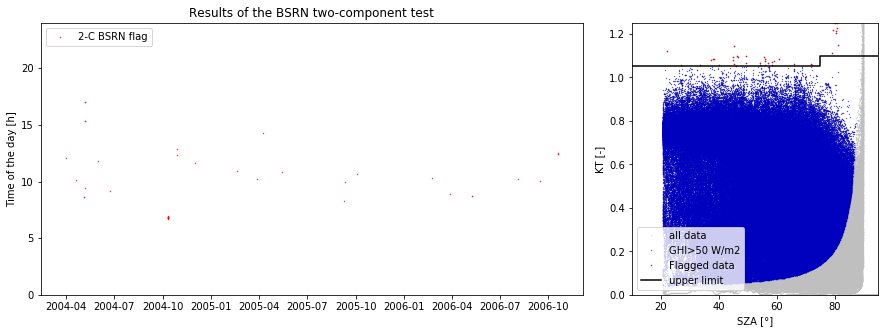

In [22]:
#%% BSRN two component test
import matplotlib.pyplot as plt

KT=QC_df.GHI/QC_df.TOA
KT[QC_df.TOA<1]=0
SZA=QC_df.THETA_Z*180/np.pi

QCFlag_Test2C_bsrn_kd=((QC_df.GHI>50) & (SZA<75) & (KT>1.05)) | ((QC_df.GHI>50) & (SZA>=75) & (KT>1.1))


plt.figure(figsize=(15,5))

ax11 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
plt.plot(day[QCFlag_Test2C_bsrn_kd],TOD[QCFlag_Test2C_bsrn_kd],'r.',markersize=0.8,label='2-C BSRN flag')
plt.ylim((0,24))
plt.legend(loc='upper left')
plt.ylabel('Time of the day [h]')
plt.title("Results of the BSRN two-component test")

ax12 = plt.subplot2grid((1, 3), (0, 2), colspan=1)

plt.plot(SZA,KT,'.',markersize=0.5,label='all data',color=[0.75,0.75,0.75])
plt.plot(SZA[QC_df.GHI>50],KT[QC_df.GHI>50],'.',markersize=0.5,label='GHI>50 W/m2',color=[0,0,0.75])
plt.plot(SZA[QCFlag_Test2C_bsrn_kd],KT[QCFlag_Test2C_bsrn_kd],'r.',markersize=1,label="Flagged data")
plt.plot([0,75,75,100],[1.05,1.05,1.1,1.1],color='k',label='upper limit')
    
plt.legend(loc='lower left')
plt.xlabel('SZA [°]')
plt.ylabel('KT [-]')

plt.xlim((10,95))
plt.ylim((0,1.25))

### 8. Two-component test from SERI QC (basic version)
***
Another two-component test set often used is the "K value" test proposed by NREL (SERI QC), which operates in a dimensionless space, with solar irradiance normalized to extraterrestrial values.
The exact upper limits for GHI and DHI are difficult to define, especially under unstable conditions with clouds, smokes or aerosols where diffuse radiation may exceed the maximum limits, leading to an increase in GHI that may in these cases exceed top atmospheric radiation or where clouds are at an elevation that allows direct radiation to rise for a brief time period, for this purpose another set of tests based on transmittances calculations is often used also, the test includes a check of diffuse horizontal transmittance and the beam transmittance as a function of the global horizontal transmittance or clearness index. These different indices are at the origin of the name of the tests. 
The transmittances are calculated from the following formulas:

* the direct beam transmittance: $K_{n}=DNI/I_{0}$
* the diffuse transmittance: $K_{d}=DHI/GHI$
* the global horizontal transmittance (clearness index): $K_{T}=GHI/TOA$

There exist very elaborate versions of this test, such as the one proposed by NREL, which is adaptive (Maxwell et al., 1993). In our study, we will limit the focus to simpler versions the test by using the limits proposed by (Norbert Geuder et al., 2015) described below.

There are two tests to qualify "K-values": a first plausibility check in the $K_{T}-K_{n}$ space and a second in the $K_{T}-K_{d}$ space. 

The tests performed in the $K_{T}-K_{n}$ space are:
 * $K_{n}>K_{T}$
 * $K_{n}<0.8$
 * $K_{T}<1$

For the qualification of measurements in the $K_{T}-K_{d}$ space, the following checks are performed:
* $K_{d}<1.05$ for $SZA<75°$
* $K_{d}<1.1$ for $SZA>75°$
* $K_{d}<0.95$ for $K_{T}>0.6$

The first two tests being included in the two-component test of BSRN, we only consider the limit of 1.1 for $K_{d}$ and won't differentiate according to the SZA here.
 
To visualize the different tests, the measurements are shown in the $K_{T}-K_{n}$ and $K_{T}-K_{d}$ spaces in the plots below. The limits specified for the different tests are represented by dotted red lines.

Wall time: 422 ms


(0, 1.2)

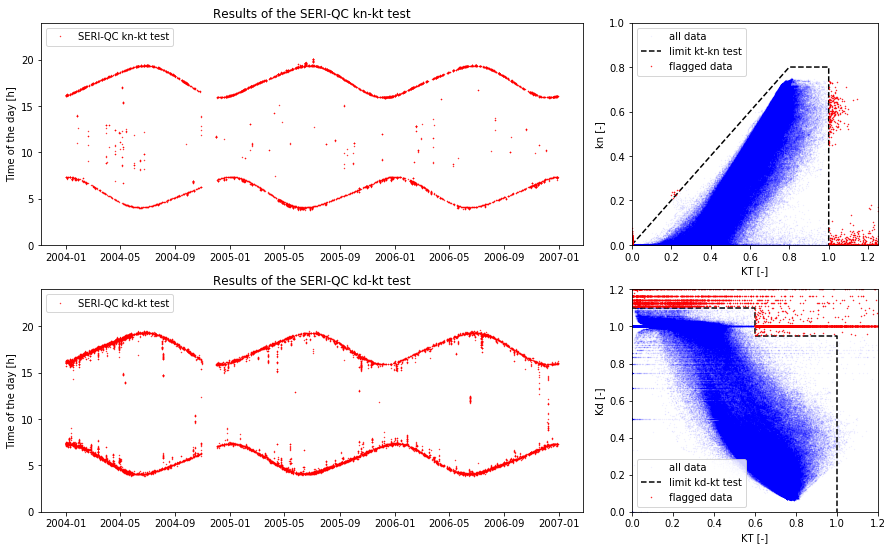

In [25]:
%%time
#%% SERI-QC two-component test

KT=QC_df.GHI/QC_df.TOA
KT[QC_df.TOA<1]=0

Kn=QC_df.BNI/QC_df.TOANI
Kn[QC_df.TOANI<1]=0

Kd=QC_df.DHI/QC_df.GHI
Kd[QC_df.GHI<1]=0

QCFlag_Test2C_seri_knkt=(Kn>KT)|(Kn>0.8)|(KT>1)
QCFlag_Test2C_seri_kdkt=((KT<0.6) & (Kd>1.1)) | ((KT>=0.6) & (Kd>0.95)) 


plt.figure(figsize=(15,9))

ax11 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
plt.plot(day[QCFlag_Test2C_seri_knkt],TOD[QCFlag_Test2C_seri_knkt],'r.',markersize=0.8,label='SERI-QC kn-kt test')
plt.ylim((0,24))
plt.legend(loc='upper left')
plt.ylabel('Time of the day [h]')
plt.title("Results of the SERI-QC kn-kt test")

ax12 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
plt.plot(KT,Kn,'b.',markersize=0.5,label='all data',alpha=0.1)
plt.plot([0,0.8,1,1],[0,0.8,0.8,0],'k--',label='limit kt-kn test')
plt.plot(KT[QCFlag_Test2C_seri_knkt],Kn[QCFlag_Test2C_seri_knkt],'r.',markersize=0.9,label='flagged data')
plt.legend(loc='upper left')
plt.xlabel('KT [-]')
plt.ylabel('kn [-]')
plt.xlim((0, 1.25))
plt.ylim((0, 1.))     
       
ax21 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
plt.plot(day[QCFlag_Test2C_seri_kdkt],TOD[QCFlag_Test2C_seri_kdkt],'r.',markersize=0.8,label='SERI-QC kd-kt test')
plt.ylim((0,24))
plt.legend(loc='upper left')
plt.ylabel('Time of the day [h]')
plt.title("Results of the SERI-QC kd-kt test")

ax22 = plt.subplot2grid((2, 3), (1, 2), colspan=1)
plt.plot(KT,Kd,'b.',markersize=0.5,label='all data',alpha=0.1)
plt.plot([0,0.6,0.6,1,1],[1.1,1.1,0.95,0.95,0],'k--',label='limit kd-kt test')
plt.plot(KT[QCFlag_Test2C_seri_kdkt],Kd[QCFlag_Test2C_seri_kdkt],'r.',markersize=0.9,label='flagged data')
plt.legend(loc='lower left')
plt.xlabel('KT [-]')
plt.ylabel('Kd [-]')

plt.xlim((0, 1.2))
plt.ylim((0, 1.2)) 

### 9. Three component test
***
The three-component test is intended to compare the GHI measured by the pyranometer and calculated from the measured DHI and DNI: 

$\left|\frac{GHI}{BNI\,cos(SZA)+DHI}-1\right|\le 0.08\, for \, SZA \le 75°$

$\left|\frac{GHI}{BNI\,cos(SZA)+DHI}-1\right|\le 0.15\, for \, SZA \gt 75°$


This test is only applied for $GHI >50 W/m^2$

Here again, we propose a data visualization corresponding to this test. For this, we can note that the three-component test consists in comparing the GHI measured with the pyranometer with an estimate of the GHI obtained with the DNI measured with a pherilyometer and the DHI measured with a shaded pyranometer using the equation linking the GHI with two other components and the zenith solar angle . Ideally, the ratio of measured and estimated GHI should be 1.0, but instruments characteristics often produce values far from unity.

Wall time: 547 ms


(0.5, 1.5)

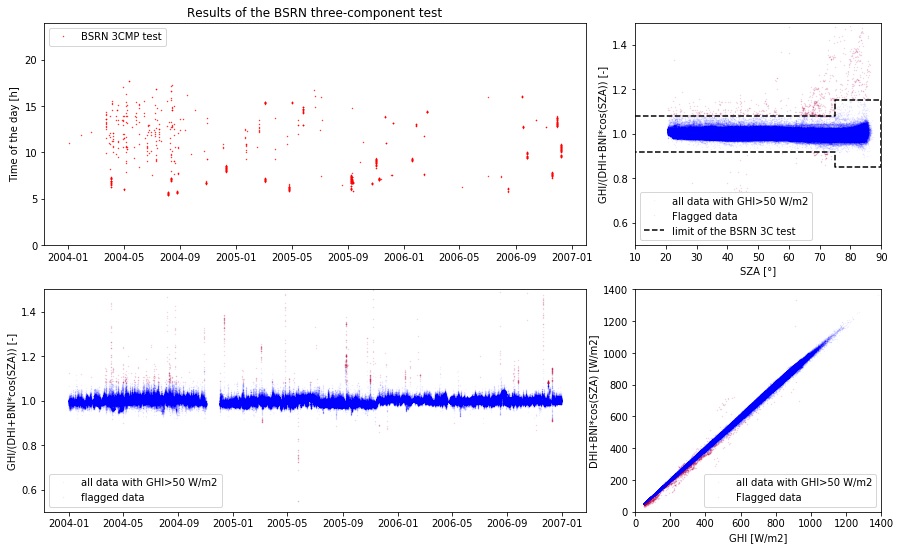

In [26]:
%%time

#%% BSRN three component tests
GHI=QC_df.GHI
GHI_est=QC_df.DHI+QC_df.BNI*np.cos(QC_df.THETA_Z)
SZA=QC_df.THETA_Z*180/np.pi

QCFlag_Test3C_bsrn_3cmp=((SZA<=75) & (GHI>50) & (np.abs(GHI/GHI_est-1)>0.08)) | ((SZA>75) & (GHI>50) & (np.abs(GHI/GHI_est-1)>0.15))

plt.figure(figsize=(15,9))

ax11 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
plt.plot(day[QCFlag_Test3C_bsrn_3cmp],TOD[QCFlag_Test3C_bsrn_3cmp],'r.',markersize=0.8,label='BSRN 3CMP test')
plt.ylim((0,24))
plt.legend(loc='upper left')
plt.ylabel('Time of the day [h]')
plt.title("Results of the BSRN three-component test")

ax22 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
plt.plot(SZA[GHI>50],GHI[GHI>50]/GHI_est[GHI>50],'b.',markersize=0.5,label='all data with GHI>50 W/m2',alpha=0.1)
plt.plot(SZA[QCFlag_Test3C_bsrn_3cmp],GHI[QCFlag_Test3C_bsrn_3cmp]/GHI_est[QCFlag_Test3C_bsrn_3cmp],'r.',markersize=1,label='Flagged data',alpha=0.1)
plt.plot([10,75,75,90,90, 75,75,10],[1.08,1.08,1.15,1.15,0.85,0.85,0.92,0.92],'k--',label='limit of the BSRN 3C test')
plt.xlabel('SZA [°]')
plt.ylabel('GHI/(DHI+BNI*cos(SZA)) [-]')

plt.legend(loc='lower left')
plt.xlim((10, 90))
plt.ylim((0.5, 1.5)) 

ax22 = plt.subplot2grid((2, 3), (1, 2), colspan=1)
plt.plot(GHI[GHI>50],GHI_est[GHI>50],'b.',markersize=0.5,label='all data with GHI>50 W/m2',alpha=0.1)
plt.plot(GHI[QCFlag_Test3C_bsrn_3cmp],GHI_est[QCFlag_Test3C_bsrn_3cmp],'r.',markersize=1,label='Flagged data',alpha=0.1)
plt.xlabel('GHI [W/m2]')
plt.ylabel('DHI+BNI*cos(SZA) [W/m2]')
plt.legend(loc='lower right')
plt.xlim((0, 1400))
plt.ylim((0, 1400)) 

ax21 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
plt.plot(QC_df.index[QC_df.GHI>50],GHI[QC_df.GHI>50]/GHI_est[QC_df.GHI>50],'b.',markersize=0.5,label='all data with GHI>50 W/m2',alpha=0.1)
plt.plot(QC_df.index[QCFlag_Test3C_bsrn_3cmp],GHI[QCFlag_Test3C_bsrn_3cmp]/GHI_est[QCFlag_Test3C_bsrn_3cmp],'r.',markersize=1,label='flagged data',alpha=0.1)
plt.ylabel('GHI/(DHI+BNI*cos(SZA)) [-]')
plt.legend(loc='lower left')
plt.ylim((0.5, 1.5)) 

###  10. Adding the a column of QC flag and saving data
***

In [132]:
QCFlag = (QC_horizon<1) & \
(QCFlag_Test1C_ppl_GHI<1) & \
(QCFlag_Test1C_erl_GHI<1) & \
(QCFlag_Test1C_ppl_DHI<1) & \
(QCFlag_Test1C_erl_DHI<1) & \
(QCFlag_Test1C_ppl_BNI<1) & \
(QCFlag_Test1C_erl_BNI<1) & \
(QCFlag_Test2C_bsrn_kd<1) & \
(QCFlag_Test2C_seri_knkt<1) & \
(QCFlag_Test2C_seri_kdkt<1) & \
(QCFlag_Test3C_bsrn_3cmp<1)

print(sum(QCflag)/len(QCflag)*100)

QC_df['QCFlag'] = QCFlag

QC_df.head()
QC_df.to_pickle('./tmpData/car_data_QC.pkl') # save the DataFrame in the Pandas pickle format

# todo: include information on the name of the QC tests and the possibility to differentiate among different QCs

98.54020801623541


In [131]:
QC_df.head()

,GHI,BNI,DHI,DELTA,OMEGA,EOT,THETA_Z,GAMMA_S0,ALPHA_S,R,TOA,TOANI,SR_h,SS_h,QCFlag
2004-01-01 00:01:00,0.0,0.0,0.0,-0.402691,55232.419717,-2.919678,2.769144,-1.198348,0.201574,0.983459,0.0,1413.370532,7.821511,16.755700,True
2004-01-01 00:02:00,0.0,0.0,0.0,-0.402690,55232.424078,-2.919678,2.768499,-1.197703,0.212449,0.983459,0.0,1413.370557,7.821507,16.755704,True
2004-01-01 00:03:00,0.0,0.0,0.0,-0.402689,55232.428440,-2.919678,2.767821,-1.197025,0.223290,0.983459,0.0,1413.370582,7.821503,16.755708,True
2004-01-01 00:04:00,0.0,0.0,0.0,-0.402688,55232.432802,-2.919678,2.767110,-1.196313,0.234097,0.983459,0.0,1413.370607,7.821498,16.755712,True
2004-01-01 00:05:00,0.0,0.0,0.0,-0.402687,55232.437164,-2.919678,2.766366,-1.195569,0.244867,0.983459,0.0,1413.370632,7.821494,16.755717,True


## Next steps:

- give access to the notebook to everyone by uploading it on github
- review the notebook and collect feedbacks
- integrate additional test
<blockquote>
    ENDORSE, NREL,DLR, JRC... 
</blockquote> 
- agreement on an approach for the flags
- consensus on the QC approach within the task, with the BSRN community
- generation of a netcdf with a new field: the results of the QC control
- automatic generation of a QC report (pdf)
- agreement on the format of the input netcdf
- preparation of conversion scripts to translate our netcdf format to other formats used in the solar community (MESOR, SRML, BSRN, ...)